## Het U-net 

**The installations of necessary packages on the virtual machine.**

In [1]:
#!pip install nibabel

**The necessary imports of the packages that are used during the program.**

In [130]:
import os
import glob
import monai
from PIL import Image
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

**The definition of the location of the database of ACDC and verification of the datapath location.**

In [131]:
data_path = "./preprocessed/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


**The selection of the correct and availble GPUs on the virtual machine.**

In [132]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

if torch.cuda.is_available():
    # CUDA
    gpu = torch.device('cuda:6')
else:
    # MacBook with >M1 chip
    gpu = torch.device('mps')

The used device is cuda:6


**A modification of the build dictonary function of the tutorials to make sure the ACDC database can be allocated on the right place.**

In [133]:
# print(img.header.structarr['pixdim'])

def build_dict_ACDC(data_path, mode='train', heart_mode='Off'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'training', 'val' or 'testing'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    dicts2 = []
    paths_mri = []
    iBegin = 1
    iEnd = 101
    
    if (mode=='test'):
        iBegin = 101
        iEnd = 151
        
    for i in tqdm(range(iBegin,iEnd)):
    # list all .png files in directory, including the path
        paths_mri.append(glob.glob(os.path.join(data_path, mode, 'patient{:03}'.format(i), '*[!gt].png')))
        # print( paths_mri)
        # make a corresponding list for all the mask files
        for mri_path in paths_mri[0]:
            # print(mri_path)
            if mode == 'test':
                suffix = 'val'
            else:
                suffix = mode
                       
            mask_path = os.path.join(mri_path[0:-4]+'_gt'+ '.png')
            # print(mask_path)
            if os.path.exists(mask_path):
                if (heart_mode=='Off'):
                    dicts.append({'img': mri_path, 'mask': mask_path})
                    # print("yes")
                    
                      
                else:
                    
                    if 'ED' in mri_path:
                        dicts.append({'img': mri_path, 'mask': mask_path})
                        
                    else:
                        dicts2.append({'img': mri_path, 'mask': mask_path})
                        
                        
                        
            paths_mri.clear()        
    if (heart_mode=='Off'):   
        return dicts
    else:
        return dicts, dicts2
        
                    

# ES_train, ED_train = build_dict_ACDC(data_path, heart_mode="On")
# ES_val, ED_val = build_dict_ACDC(data_path,mode = 'test',heart_mode="On")
# print(len(ED_train))
# print(len(ES_val))

**A modification of the LoadTranform function to make sure that only the image data is used in the DL model.**

Some things are commented out for adaptation purposes later in the project

In [134]:
class LoadMriData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = Image.open(sample['img']).convert('L') # import as grayscale image
        # image = nib.load(sample['img']).get_fdata()
        image = np.array(image, dtype=np.uint8)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        # mask = nib.load(sample['mask']).get_fdata()
        mask = np.array(mask, dtype=np.uint8)
        # slice = sample['slice']
        # mask has value 255 on rib pixels. Convert to binary array
        mask[np.logical_and(np.logical_and(mask!=85,mask!=170),mask!=255)] = 0
        mask[np.where(mask==255)] = 1
        mask[np.where(mask==85)] = 2
        mask[np.where(mask==170)] = 3
        # mask[np.where(mask>0 & mask <255)] = 0.5
        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

In [135]:
# test the function np.logcial_end (used above)
t = np.array([1,2,2,3,3,3,3,2,7,7])
print(t)
print(np.where(t==1,2,3))
t[np.logical_and(np.logical_and(t!=2,t!=3),t!=7)]=0
print(t)
print(np.ma.masked_where(t!=2,t))

[1 2 2 3 3 3 3 2 7 7]
[2 3 3 3 3 3 3 3 3 3]
[0 2 2 3 3 3 3 2 7 7]
[-- 2 2 -- -- -- -- 2 -- --]


**A function, modified from tutorials, to visualize the images together with their masks.**

In [136]:
def visualize_mri_sample(sample, title=None):
# Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    plt.figure(figsize=[10,7])
    
    mask1 = np.logical_and(np.logical_and(mask==0,mask==1),mask==2)
    mask2 = np.logical_and(np.logical_and(mask==0,mask==2),mask==3)
    mask3=  np.logical_and(np.logical_and(mask==0,mask==1),mask==3)
  
    overlay_mask1 = np.ma.masked_where(mask!=1, mask)
    overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
    overlay_mask3 = np.ma.masked_where(mask!=3, mask)
    plt.imshow(image, 'gray')
    plt.imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')

    if title is not None:
        plt.title(title)
    plt.show()

**Testing the function whether they perform as intended.**

In [137]:
train_dict_list = build_dict_ACDC(data_path)
val_dict_list = build_dict_ACDC(data_path,mode='test')
# create transform and datasets/-loaders

# ⌨️ code your answer here
composed_transform = monai.transforms.Compose([LoadMriData(),
                                                monai.transforms.AddChanneld(keys=['img', 'mask']),
                                                monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
                                                monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi, prob=6/7, mode=['bilinear', 'nearest'],padding_mode=['zeros','zeros']),
                                                #monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1/2, spatial_axis=1),  
                                                ])

train_dataset = monai.data.CacheDataset(train_dict_list, transform=composed_transform)
val_dataset = monai.data.CacheDataset(val_dict_list, transform=composed_transform)

100%|██████████| 50/50 [00:00<00:00, 115.09it/s]
/home/jovyan/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 1076/1076 [00:04<00:00, 236.29it/s]


**show 5 random images + masks in training dataset**

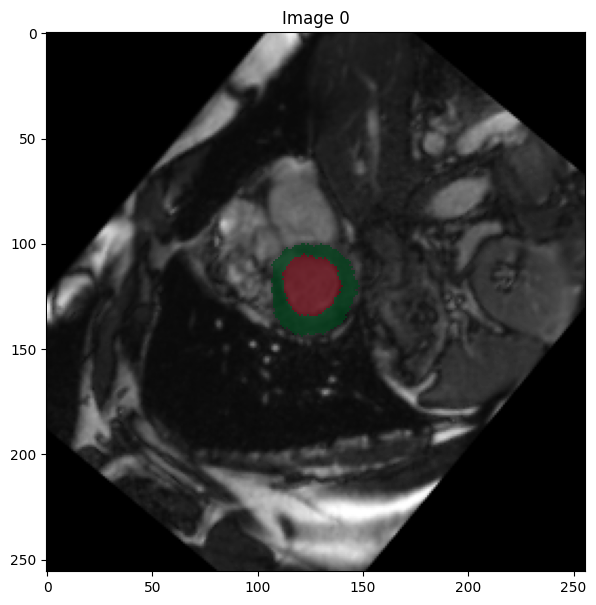

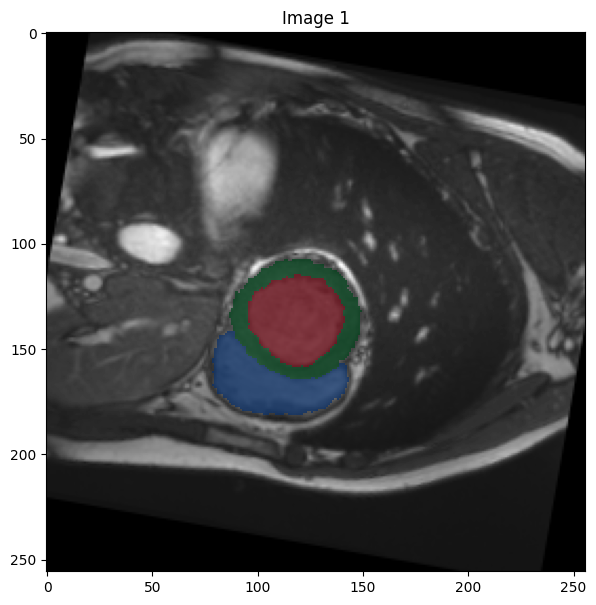

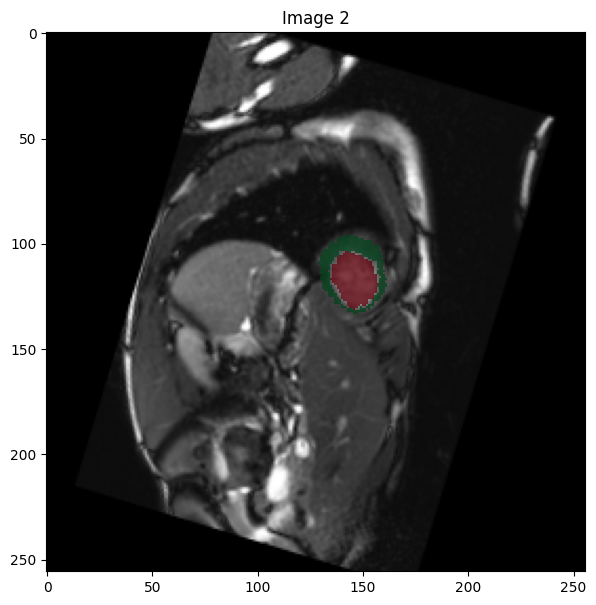

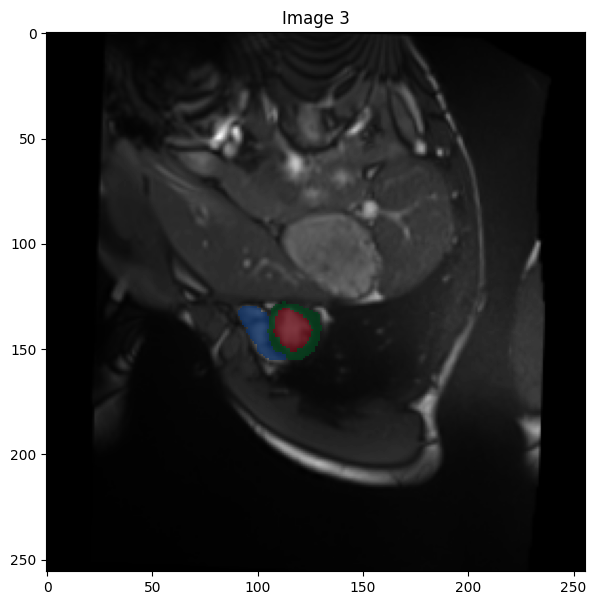

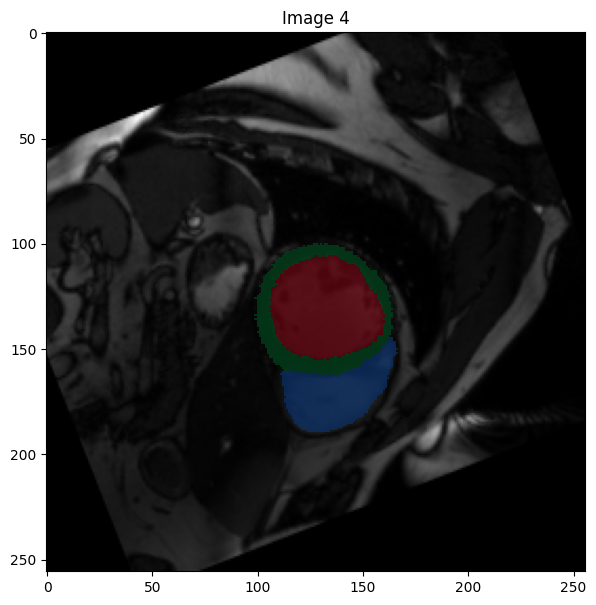

In [138]:
for i in range(5):
    value = np.random.randint(0, len(train_dataset))
    image = train_dataset[value]
    visualize_mri_sample(image, "Image " + str(i))

**Create a dataloader for the corresponding data.**

In [139]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

**Definition of the basic U-net model based on the tutorial.**

In [146]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


**Loss function & Optimizer**

In [147]:
loss_function = monai.losses.DiceLoss(softmax=True, batch=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**Some monai/wandb functions**

In [148]:
# def from_compose_to_list(transform_compose):
#     """
#     Transform an object monai.transforms.Compose in a list fully describing the transform.
#     /!\ Random seed is not saved, then reproducibility is not enabled.
#     """
#     from copy import deepcopy
        
#     if not isinstance(transform_compose, monai.transforms.Compose):
#         raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
#     output_list = list()
#     for transform in transform_compose.transforms:
#         kwargs = deepcopy(vars(transform))
        
#         # Remove attributes which are not arguments
#         args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
#         for key, obj in vars(transform).items():
#             if key not in args:
#                 del kwargs[key]

#         output_list.append({"class": transform.__class__, "kwargs": kwargs})
#     return output_list

# def from_list_to_compose(transform_list):
#     """
#     Transform a list in the corresponding monai.transforms.Compose object.
#     """
    
#     if not isinstance(transform_list, list):
#         raise TypeError("transform_list should be a list.")
    
#     pre_compose_list = list()
    
#     for transform_dict in transform_list:
#         if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
#             raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        
#         try:
#             transform = transform_dict['class'](**transform_dict['kwargs'])
#         except TypeError: # Classes have been converted to str after saving
#             transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])
            
#         pre_compose_list.append(transform)
        
#     return monai.transforms.Compose(pre_compose_list)

# WANDB deel heb ik nog niet toegevoeg (zie code onderaan om te zien hoe je van de output van je netwerk naar een mask kunt gaan (mbv de argmax functie <-- moet nog toegevoegd worden. Dice loss moet ook nog berekend worden op de test set, maar daarvoor moet eerst de argmax worden toegevoegd!!!)

In [149]:
import wandb
import datetime

# now = datetime.datetime.now() # current date and time
# nu = now.strftime('%c')

# run = wandb.init(
#     project='tutorial3_ex2_left_and_right_rib',
#     name= nu,
#     config={
#         'loss function': str(loss_function), 
#         'lr': optimizer.param_groups[0]["lr"],
#         'transform': from_compose_to_list(composed_transform),
#         'batch_size': train_dataloader.batch_size,
#     }
# )
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

# run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

# def wandb_masks(mask_output, mask_gt):
#     """ Function that generates a mask dictionary in format that W&B requires """

#     # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
# #     softmax = torch.nn.Softmax()
# #     mask_output = softmax(mask_output)
# #     mask_output = torch.argmax(mask_output,1)
    
# #     # Transform masks to numpy arrays on CPU
# #     # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
# #     # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
# #     mask_output = mask_output.squeeze().detach().cpu().numpy()
# #     mask_gt = mask_gt.squeeze().detach().cpu().numpy()

#     # Create mask dictionary with class label and insert masks
#     class_labels = {1: 'ribs'}
#     masks = {
#         'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
#         'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
#     }
#     return masks

# def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
#     """ Function that logs ongoing training variables to W&B """

#     # Create list of images that have segmentation masks for model output and ground truth
#     log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
#                 mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

#     # Send epoch, losses and images to W&B
#     wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    
# ⌨️ WRITE YOUR TRAINING LOOP HERE

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device, val_freq=1):
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(epochs)):
        model.train()
        steps = 0
        epoch_loss = 0

        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['mask'].float().to(device)
            output = model(images) 
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1
            train_ep_loss = epoch_loss/steps
        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                output = model(images) 
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
                val_ep_loss = val_epoch_loss/steps
            val_loss.append(val_epoch_loss/steps)
        #log_to_wandb(epoch, train_ep_loss, val_ep_loss, batch, output)
    
    return train_loss, val_loss, model

val_freq = 10
n_epochs = 50

train_loss, val_loss, model = train_medmnist(model, train_dataloader, val_dataloader, optimizer, n_epochs, gpu, val_freq)


# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
# run.finish()

  2%|▏         | 1/50 [00:39<32:29, 39.79s/it]


KeyboardInterrupt: 

In [ ]:
# Plot training and validation loss

plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(np.linspace(0, n_epochs, int(n_epochs/val_freq)), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the X-ray image, the ground truth (green)
    and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    # inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256])
    inferer = monai.inferers.SimpleInferer()
    discrete_transform = monai.transforms.AsDiscrete(argmax = True)
    Softmax = torch.nn.Softmax()
    with torch.no_grad():
        output = discrete_transform(Softmax(inferer(sample['img'].to(gpu), network=model).cpu())).squeeze()
    
    fig, ax = plt.subplots(1,3, figsize = [12, 10])
     
    # mask = ground truth segmentation
    mask = np.squeeze(sample['mask'])    
    mask1 = np.logical_and(np.logical_and(mask==0,mask==1),mask==2)
    mask2 = np.logical_and(np.logical_and(mask==0,mask==2),mask==3)
    mask3=  np.logical_and(np.logical_and(mask==0,mask==1),mask==3)
    
    # create mask for background
    overlay_mask1 = np.ma.masked_where(mask!=1, mask)
    overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
    overlay_mask3 = np.ma.masked_where(mask!=3, mask)  
    
    # Plot MRI image
    ax[0].imshow(sample["img"].squeeze(), 'gray')    
    ax[0].set_title('Grey scale MRI')
    
    # Plot ground truth
    ax[1].imshow(sample["img"].squeeze(), 'gray')
    ax[1].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[1].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[1].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[1].set_title('Ground truth')
    
    # Plot prediction  
    # Predction (= output from neural network), seperate into different classes
    output1 = output[1,:,:] # ronde ventrikel
    output2 = output[2,:,:] # puntige ventrikel
    output3 = output[3,:,:] # myocardium

    ax[2].imshow(sample['img'].squeeze(), 'gray')    # grey scale image
    
    # infer output of network
    with torch.no_grad():  
        output = Softmax(inferer(sample['img'].to(gpu), network=model).cpu()).squeeze().detach().numpy()
    
    classes = np.argmax(output,axis=0) # find class with highest probabillity per pixel
    # bottom two lines used during testing of code
    print(np.unique(classes))
    print(np.shape(classes))
    
    mask = classes   # rename (because code for ground truth was copied, and there I named them 'mask' instead of 'classes')
    # select the different components (= value 1, 2 or 3 for myo, LV and RV)
    mask1 = np.logical_and(np.logical_and(mask==0,mask==1),mask==2)
    mask2 = np.logical_and(np.logical_and(mask==0,mask==2),mask==3)
    mask3=  np.logical_and(np.logical_and(mask==0,mask==1),mask==3)
    
    # create mask for background
    overlay_mask1 = np.ma.masked_where(mask!=1, mask)
    overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
    overlay_mask3 = np.ma.masked_where(mask!=3, mask)  
      
    ax[2].imshow(sample["img"].squeeze(), 'gray')
    ax[2].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[2].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[2].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[2].set_title('Prediction')

    # possibillity to plot histogram (used during testing of code --> check if values are elements of {0,1,2,3})
#     ax[3].hist(np.ndarray.flatten(output3.detach().numpy()))
#     ax[3].hist(np.ndarray.flatten(classes))
#     print(np.matrix.max(output1))
#     print(np.matrix.min(output1))
    # print(np.shape(output))
        # print(output1.max())

In [ ]:
# test set,
test_dict = build_dict_ACDC(data_path, mode='test')
test_transform = monai.transforms.Compose([LoadMriData(),
                                           monai.transforms.AddChanneld(keys=['img', 'mask']),
                                           monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
                                           #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
                                           #monai.transforms.Resized(keys = ['img','mask'],spatial_size=(1024,1024), mode=['bilinear','nearest'])
                                           #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
                                            ])
test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)

In [ ]:
#show 20 examples
limit =20
for index, sample in enumerate(test_loader):
    visual_evaluation(sample, model)
    if index == limit: # There's gotta be a better way.
        break       


# Troep die gebruikt is bij het testen van de code:

KeyboardInterrupt: 

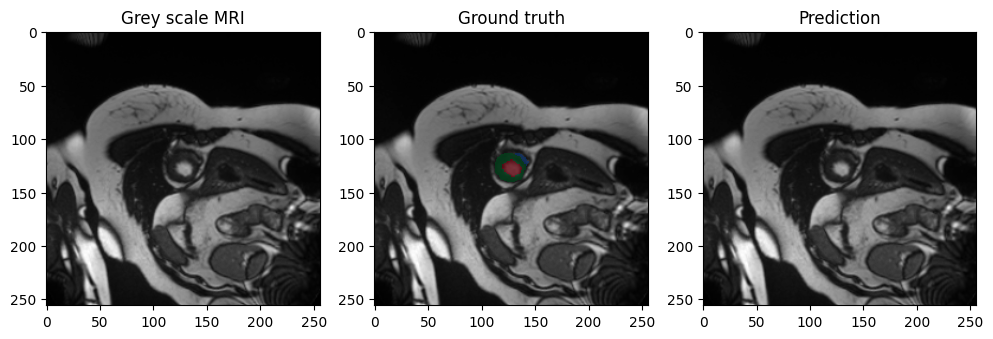

Error in callback <function flush_figures at 0x7f6b818e1160> (for post_execute):


KeyboardInterrupt: 

In [40]:
# for sample in test_loader:
#     visual_evaluation(sample, model)

In [124]:
# import matplotlib as mpl
# mpl.pyplot.close('all')

In [45]:
# visual_evaluation(test_transform(test_set[1]), model)

RuntimeError: applying transform <__main__.LoadMriData object at 0x7f6b81ea1d90>

In [118]:
# hist(np.ndarray.flatten(train_loader[i]['img']))

In [35]:
# test = np.array([10, 10.1, 0.85])
# np.argmax(test)

1

In [63]:
# np.shape(test_dict[1])

()

ValueError: Sequence must have length 1, got 2.